# Load Data

In [1]:
from sklearn.datasets import load_digits

X, y = load_digits(return_X_y=True)

# Split into Train and Test Set

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Train Model using Logstical Regression

Let's assume this is n_labelled data set, where we asked experts to provide us with labels for. Pretend that this is such a major task and expensive for them to do, we should value this data and is formly called the <i> representative images </i>.

In [3]:
from sklearn.linear_model import LogisticRegression

n_labelled = 50
log_reg = LogisticRegression(random_state=42, verbose=0, solver= 'lbfgs', multi_class= 'ovr')
log_reg.fit(X_train[:n_labelled], y_train[:n_labelled])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [4]:
log_reg.score(X_test, y_test)

0.8333333333333334

##### 83.3% is pretty small in comparison to training the data with the entire training set as we done in Supervised Learning, where we obtained around 96%

### In Semi-Supervised Learning we obtain the clusters by using Kmean.fit_transform on the unlabelled instances. Once the data has been transformed we can find the minimum distance of the instance in that axis, which represents that it is closest to that centroid.

In [5]:
from sklearn.cluster import KMeans
import numpy as np

k = 50

kmeans = KMeans(n_clusters=k)

#distances to each cluster (i.e. 50), the fit_transform value gives distances to each centroid.
#The smaller the value the closer the instance to that respective centroid. 
X_digits_dist = kmeans.fit_transform(X_train) #Compute clustering and transform X to cluster-distance space.
X_representative_digits_idx = np.argmin(X_digits_dist, axis=0) #returns the index of the minimum value 
X_representative_digits = X_train[X_representative_digits_idx] #Find 
X_representative_digits[0].shape #1 instance is a column vector 

(64,)

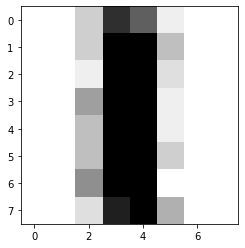

In [6]:
import matplotlib.pyplot as plt
plt.imshow(X_representative_digits[0].reshape(8,8), cmap="binary")

In [7]:
X_digits_dist[0]

array([49.19056693, 39.82275014, 42.85118114, 39.5738882 , 30.27426286,
       35.17742726, 53.12751521, 54.72080254, 40.04708398, 47.3609317 ,
       44.23473528, 38.09022133, 53.36938561, 40.51434449, 40.35164363,
       46.07325473, 49.97866892, 34.8376621 , 41.71892778, 57.42732763,
       50.45160497, 36.33047088, 48.12483766, 40.27033648, 38.18875427,
       42.43835565, 50.24111862, 47.49722214, 45.27280136, 37.70445962,
       45.55121539, 45.906941  , 46.05659428, 49.8304124 , 43.34608181,
       39.02487723, 43.38045643, 54.01277627, 46.32083092, 52.81288377,
       34.42478386, 50.273327  , 32.53112934, 48.64734249, 57.14698398,
       45.07864463, 43.02925757, 57.3441275 , 44.40733069, 46.14696091])

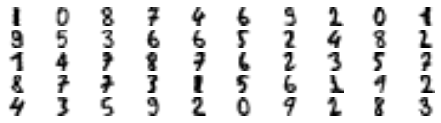

In [8]:
#Plot the 50 representative images
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary", interpolation="bilinear")
    plt.axis('off')

In [9]:
import numpy as np

y_resentative_digits = np.array([1, 0, 8, 7, 4, 6, 9, 2, 0, 1,
                                  9, 5, 3, 6, 6, 5, 2, 4, 8, 2,
                                  1, 4, 7, 8, 7, 6, 2, 3, 5, 7,
                                  8, 7, 7, 3, 1, 5, 6, 2, 9, 2,
                                  4, 3, 5, 9, 2, 0, 9, 2, 8, 3])

In [10]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_representative_digits, y_resentative_digits)
log_reg.score(X_test, y_test)

0.9155555555555556

## That is almost a 10% jump in the score by just labelling 50 of the representative instances. 

## Let's try <i> Label Propagation </i>, where we will label other instances within the same cluster that fall inside a percentile.
If we label all instances within the same cluster then we may end up labelling some outliers (i.e. labels that look like 3 when they are 5, for exampe). See Code below. 

In [11]:
#create an empty array where you will house the X_train labels.
y_train_propagated = np.empty(len(X_train), dtype= np.int32)
for i in range(k):
    y_train_propagated[kmeans.labels_ == i] = y_resentative_digits[i]

Now Train model again with these new labels (y_train_propagated)

In [12]:
log_reg = LogisticRegression(random_state=42, max_iter=5000, solver= 'lbfgs', multi_class= 'ovr')
log_reg.fit(X_train, y_train_propagated)
log_reg.score(X_test, y_test)

0.9088888888888889

##### We managed to decrease the accuracy marginally but trying again with 20% of the instances that are closest to the centroid. 

In [13]:
import numpy as np
percentile_closest = 20

#get the minimum distance of each instance to a centroid
X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]  

# remind yourself what each matrix is below
# X_cluster_dist[0]
# kmeans.labels_
# X_digits_dist[0, 1]

#create a loop that loops over 
for i in range(k):
    # For each label assign True or False values based on i, the returned cluster distances can be used to find the %
    cluster_dist = X_cluster_dist[kmeans.labels_ == i]
    
    #Return the percentile_closest percentile, in this case, return the 20th percentile distance in that area
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    
    #above_cutoff is an array of boolean values containing which values fall under the 20th
    above_cutoff = (X_cluster_dist > cutoff_distance)
    
    # & is simply a vectorized bit 'and' operation (i.e. it produces true and false values comparing each array)
    X_cluster_dist[(kmeans.labels_ == i) & above_cutoff] = -1
    
    

In [14]:
#for values that are not equal to -1,
partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train[partially_propagated]

In [15]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)
log_reg.score(X_test, y_test)

0.9288888888888889

## Success! 

#### Overall, we went from 83.3% accuracy to 92.89% with just 50 Labelled Instances. 

Conversely, we could easily change the code to label instances the classifier is least sure about (i.e. the instances that fall between two clusters). We can label these and then train a new model with these additional labels, similiar to the above.